In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

posts_df = pd.read_csv("../data/the-reddit-dataset-dataset-posts.csv")
comments_df = pd.read_csv("../data/the-reddit-dataset-dataset-comments.csv")
decor_df = pd.read_csv("../data/cleaned_decor.csv")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\color\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\color\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"&amp;|&nbsp;", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

posts_df['full_text'] = posts_df['title'].fillna('') + " " + posts_df['selftext'].fillna('')
posts_df['cleaned'] = posts_df['full_text'].apply(clean_text)


In [5]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('english'))
custom_stopwords.update([
    'im', 'dont', 'like', 'get', 'got', 'one', 'make', 'know',
    'reddit', 'post', 'people', 'things', 'thing', 'amp',
    'today', 'really', 'also', 'time'
])


In [6]:
# posts_df.columns
# Index(['index', 'type', 'id', 'subreddit.id', 'subreddit.name',
#        'subreddit.nsfw', 'created_utc', 'permalink', 'domain', 'url',
#        'selftext', 'title', 'score', 'full_text', 'cleaned'],
#       dtype='object')

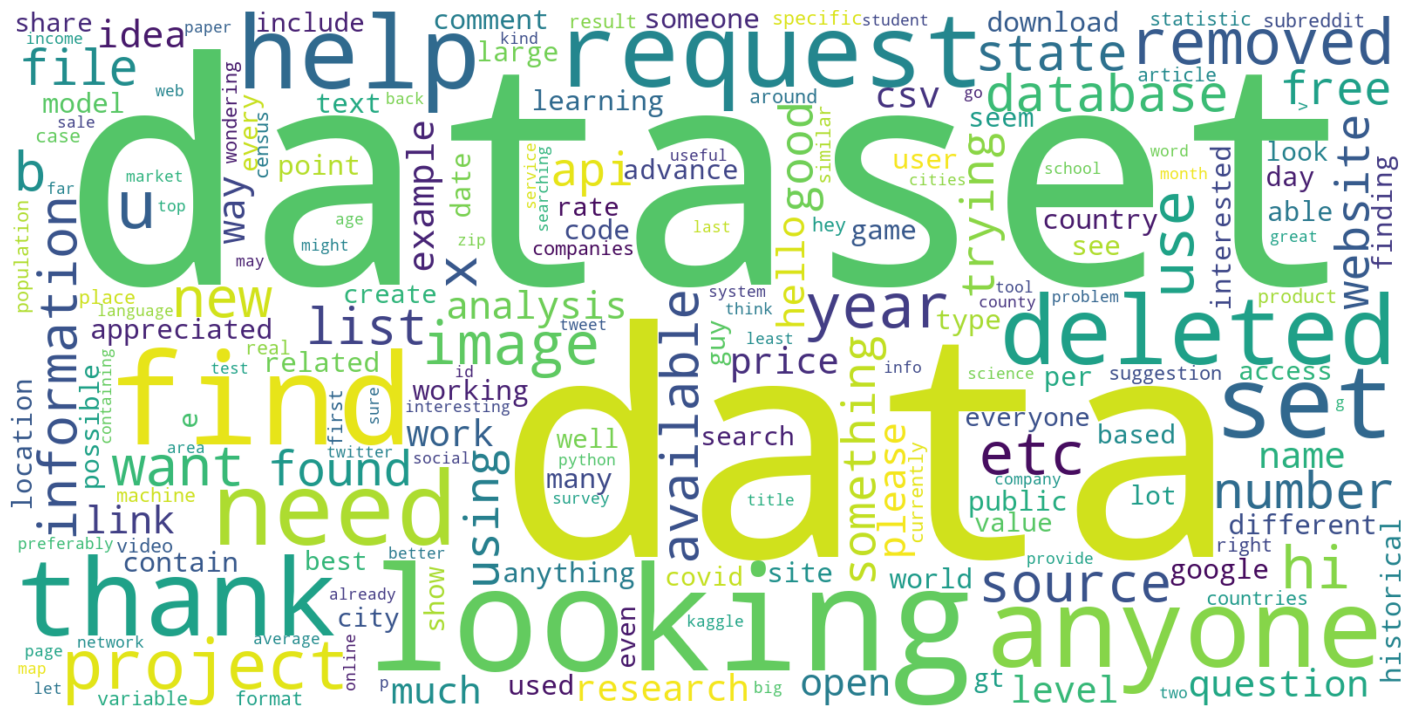

In [7]:
all_text = " ".join(posts_df['cleaned'])

wc = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    stopwords=custom_stopwords,
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(18,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


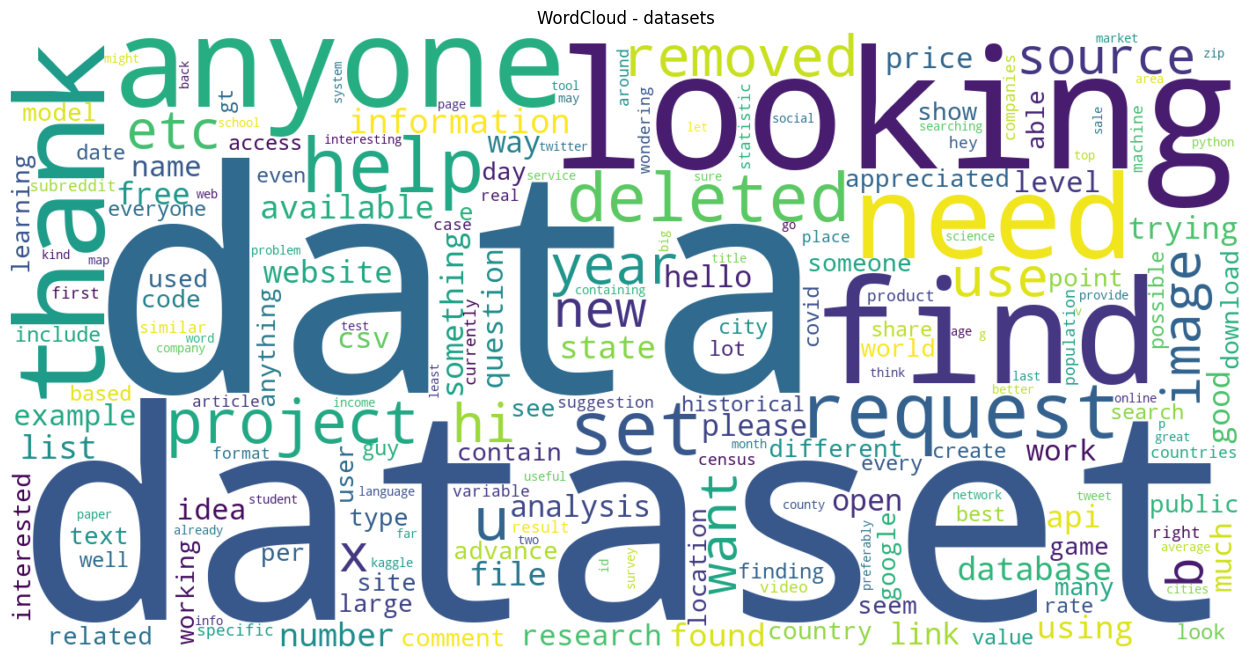

In [8]:
top_subs = posts_df['subreddit.name'].value_counts().head(3).index

for sub in top_subs:
    sub_text = " ".join(posts_df[posts_df['subreddit.name']==sub]['cleaned'])

    wc = WordCloud(
        width=1400, height=700,
        background_color='white',
        stopwords=custom_stopwords,
        collocations=False
    ).generate(sub_text)

    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud - {sub}")
    plt.axis('off')
    plt.show()


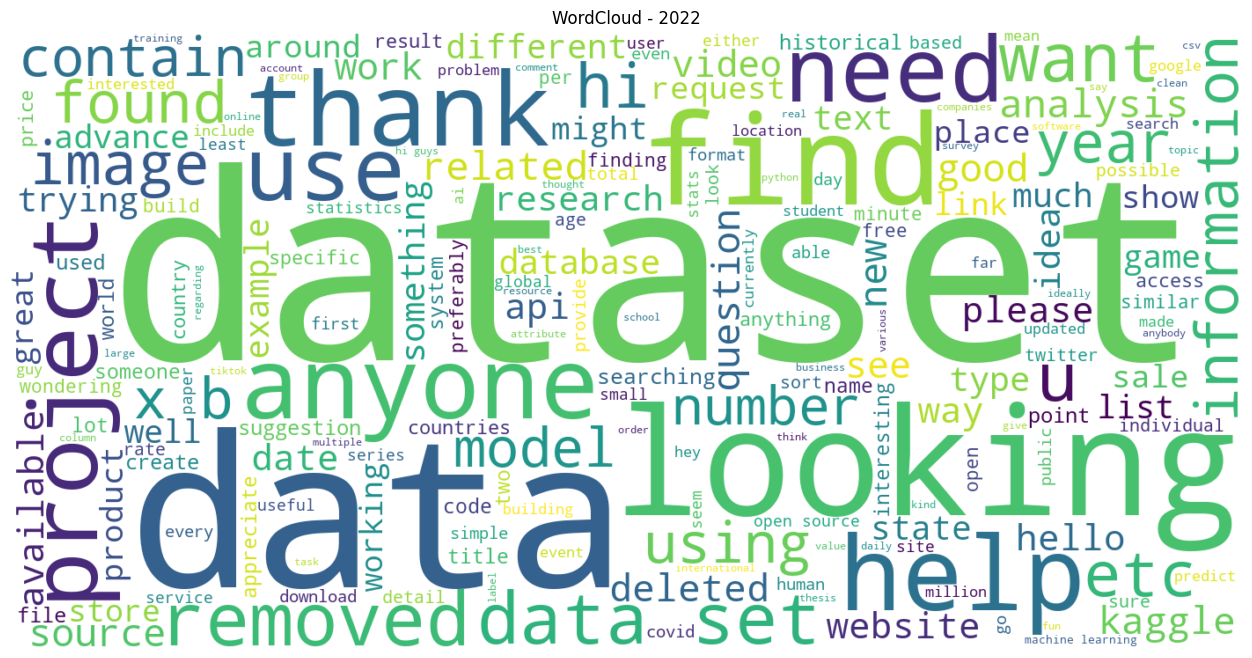

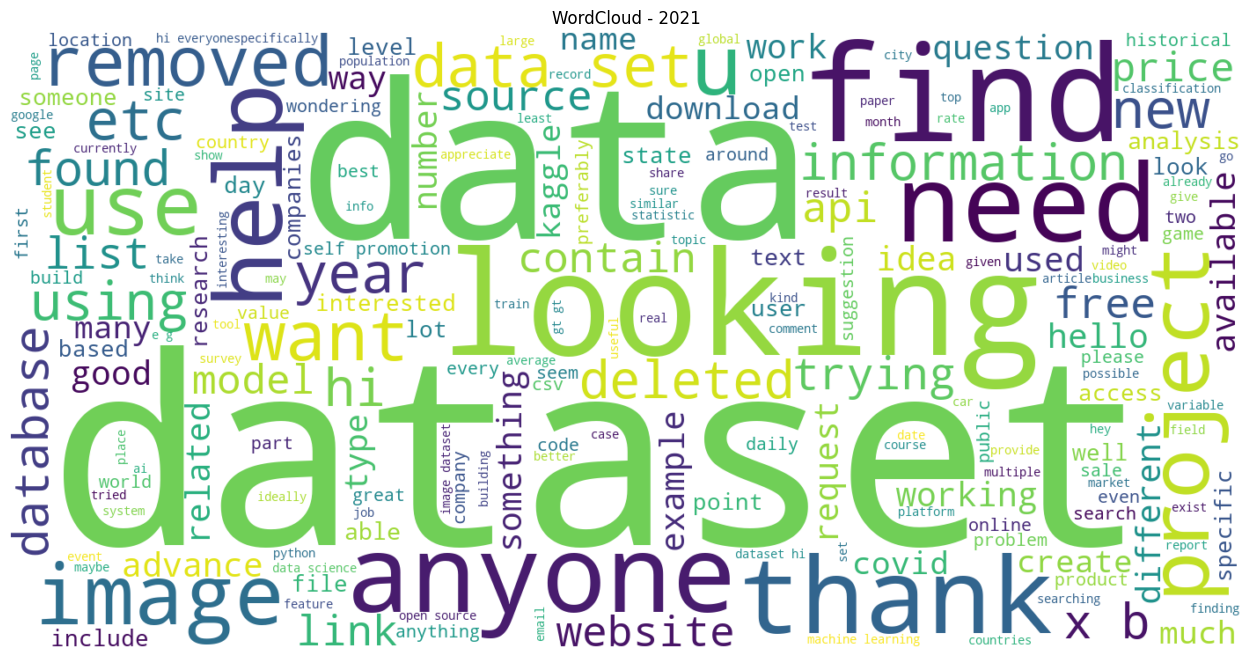

In [9]:
posts_df['year'] = pd.to_datetime(posts_df['created_utc'], unit='s').dt.year
years = posts_df['year'].dropna().unique()[:2]  # 최근 2개 연도 비교 예시

for y in years:
    y_text = " ".join(posts_df[posts_df['year']==y]['cleaned'])

    wc = WordCloud(
        width=1400, height=700,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(y_text)

    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud - {y}")
    plt.axis('off')
    plt.show()


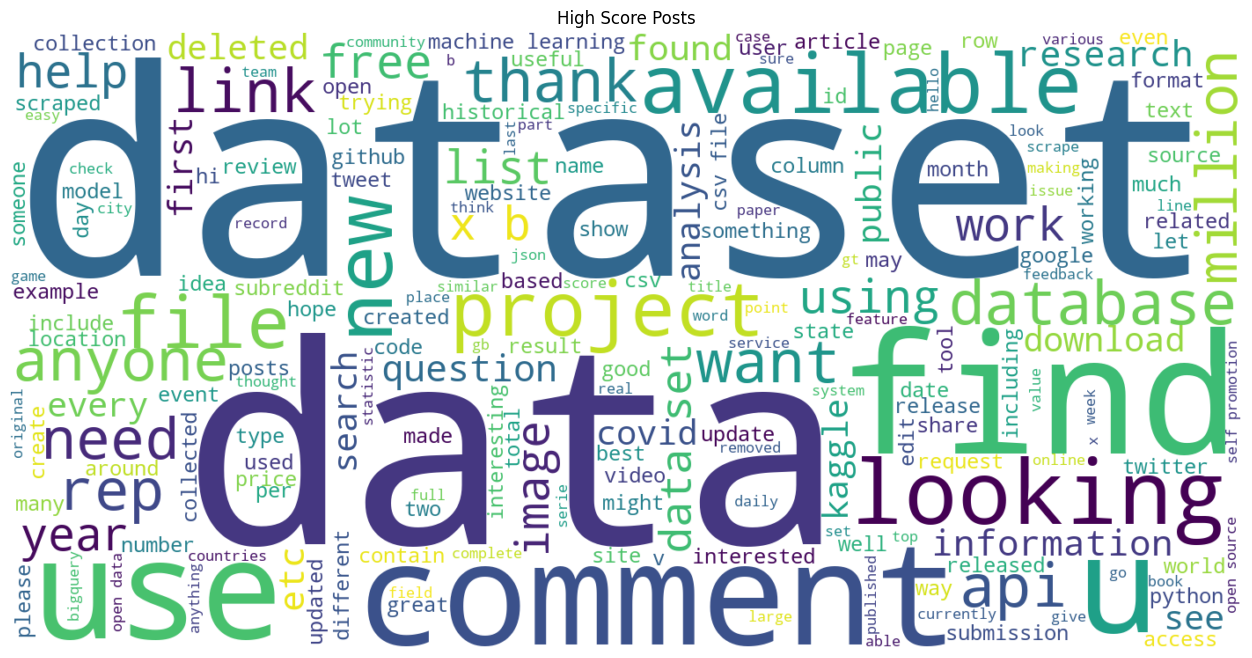

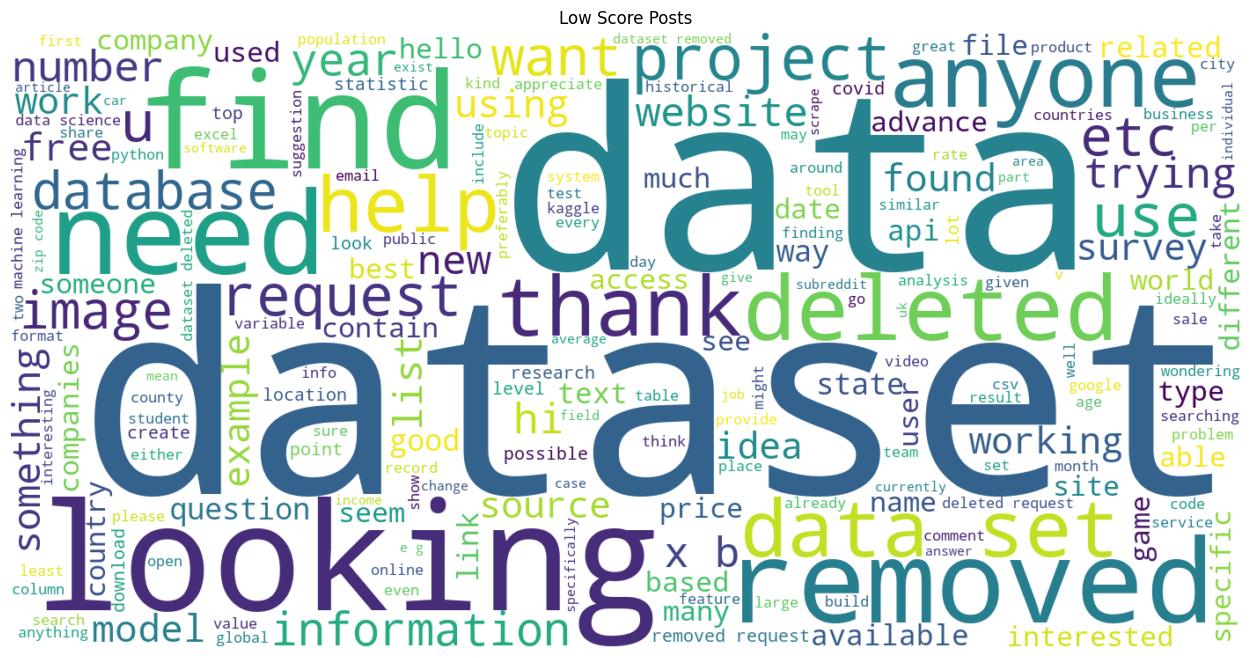

In [10]:
high_score = posts_df[posts_df['score'] >= posts_df['score'].quantile(0.9)]
low_score = posts_df[posts_df['score'] <= posts_df['score'].quantile(0.1)]

def plot_wc(df, title):
    text = " ".join(df['cleaned'])
    wc = WordCloud(width=1400, height=700, background_color='white',
                   stopwords=custom_stopwords).generate(text)
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wc(high_score, "High Score Posts")
plot_wc(low_score, "Low Score Posts")


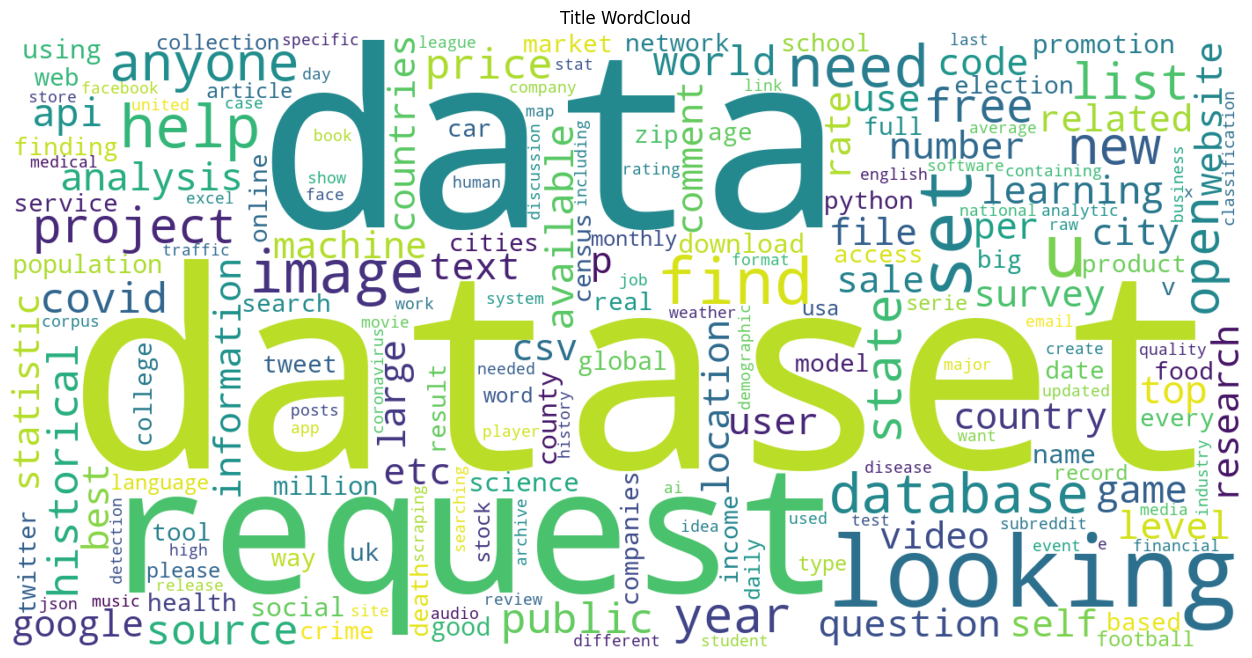

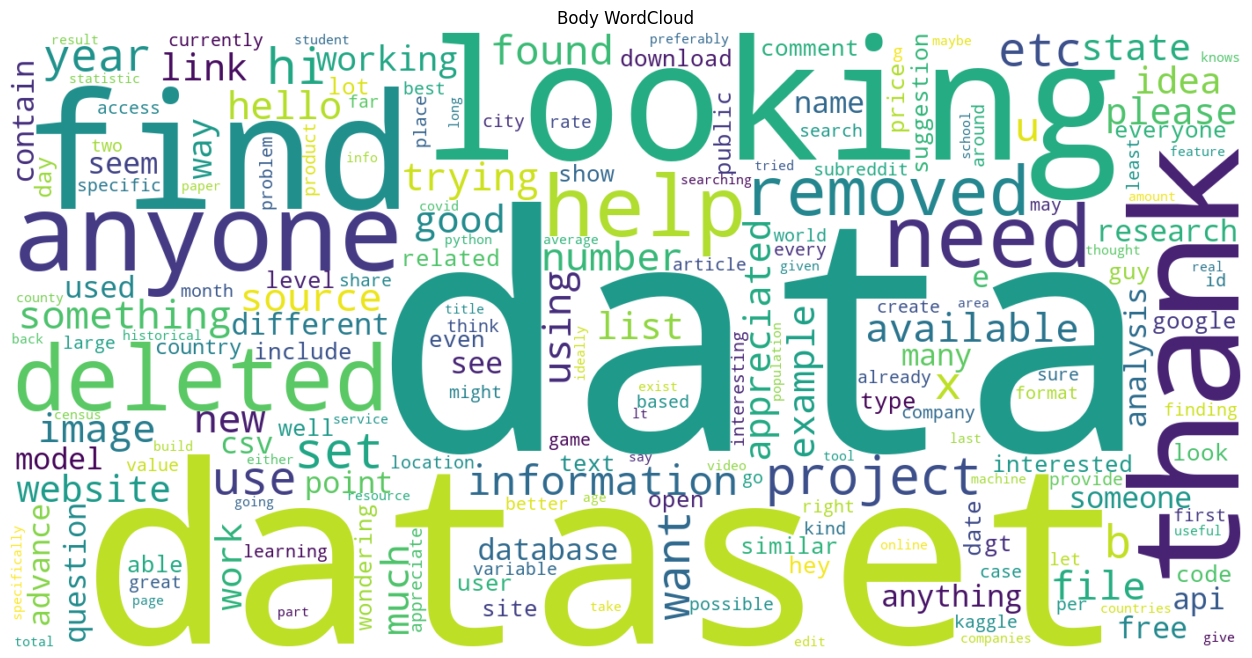

In [11]:
title_text = " ".join(posts_df['title'].fillna('').apply(clean_text))
body_text  = " ".join(posts_df['selftext'].fillna('').apply(clean_text))

for text, label in [(title_text, "Title"), (body_text, "Body")]:
    wc = WordCloud(width=1400, height=700, background_color='white',
                   stopwords=custom_stopwords, collocations=False).generate(text)
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"{label} WordCloud")
    plt.axis('off')
    plt.show()


In [12]:
tokens = " ".join(posts_df['cleaned']).split()

bigrams_list = list(bigrams(tokens))
trigrams_list = list(trigrams(tokens))

bigram_freq = Counter(bigrams_list).most_common(100)
trigram_freq = Counter(trigrams_list).most_common(100)

bigram_words = [" ".join(b) for b,c in bigram_freq]
trigram_words = [" ".join(t) for t,c in trigram_freq]

bigram_text = " ".join(bigram_words)
trigram_text = " ".join(trigram_words)


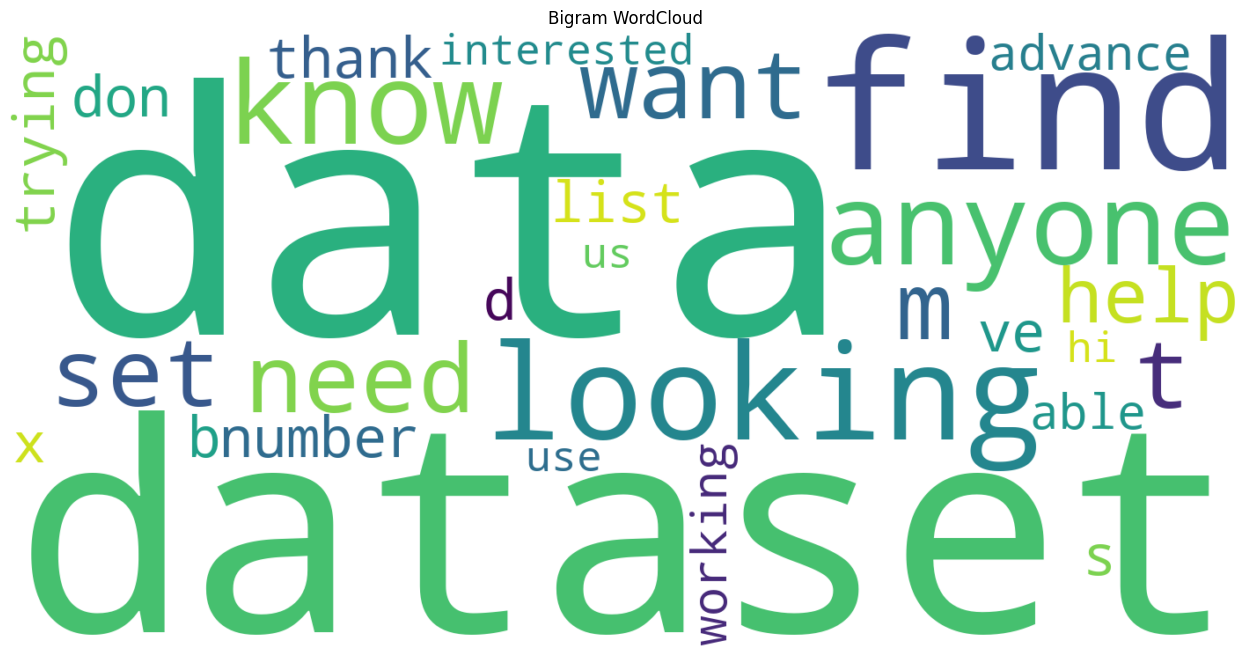

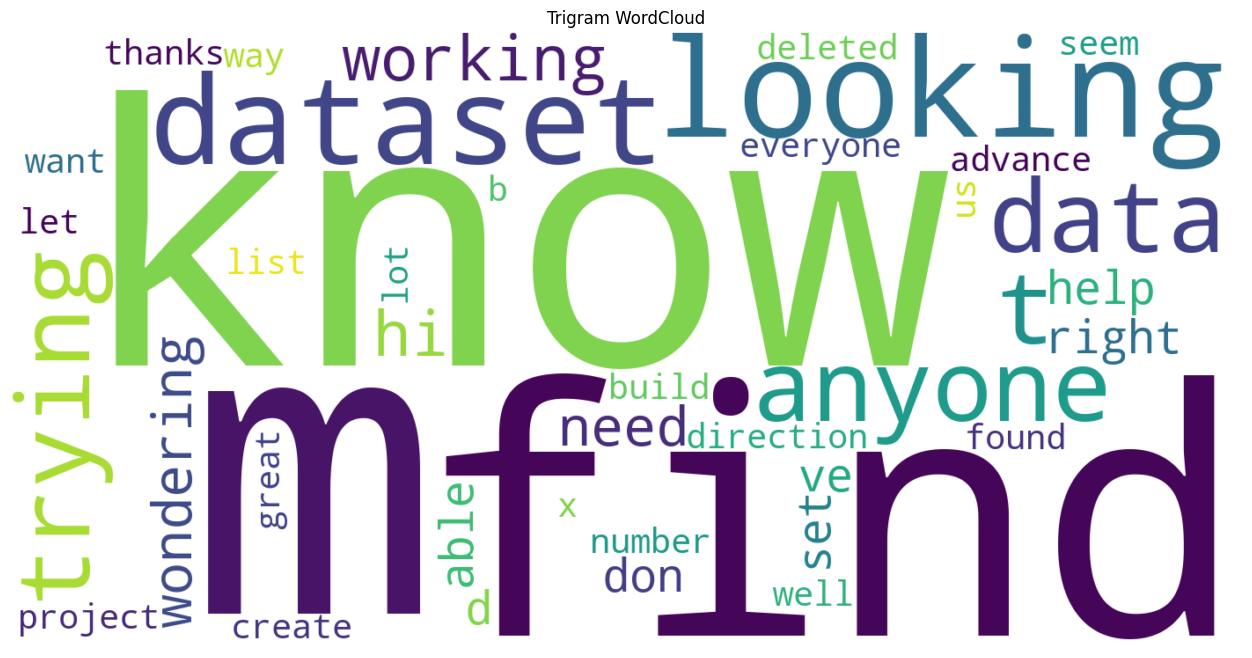

In [13]:

for t, label in [(bigram_text, "Bigram"), (trigram_text, "Trigram")]:
    wc = WordCloud(width=1400, height=700, background_color='white').generate(t)
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"{label} WordCloud")
    plt.axis('off')
    plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\color\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


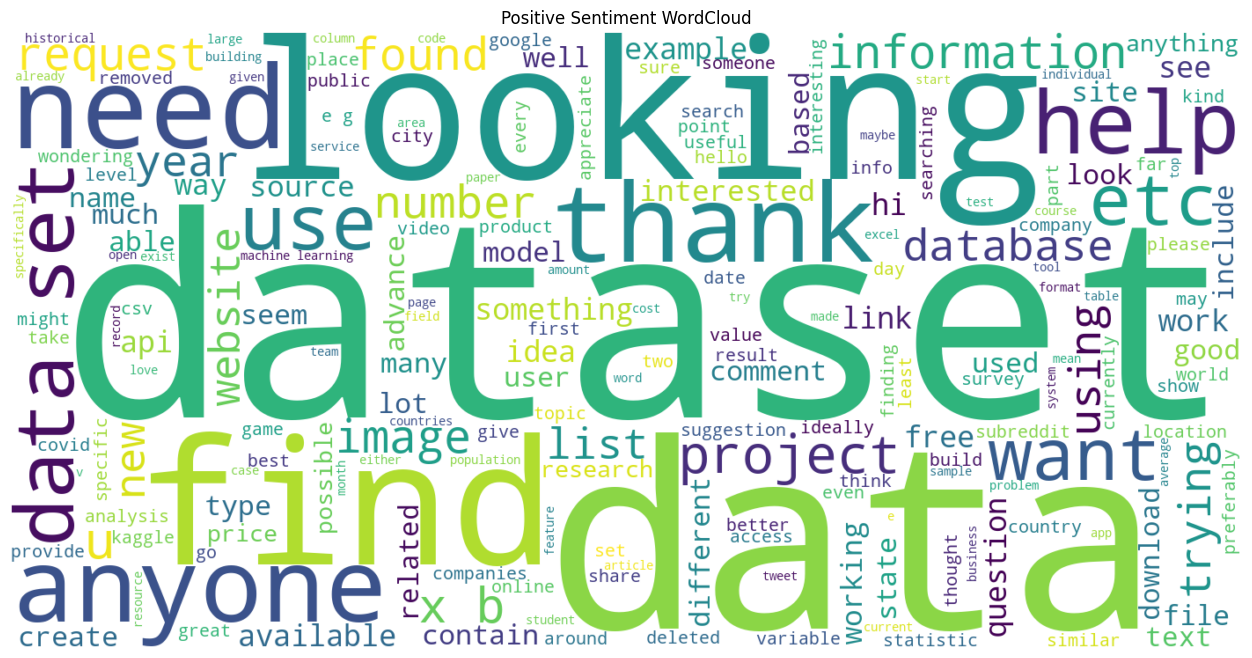

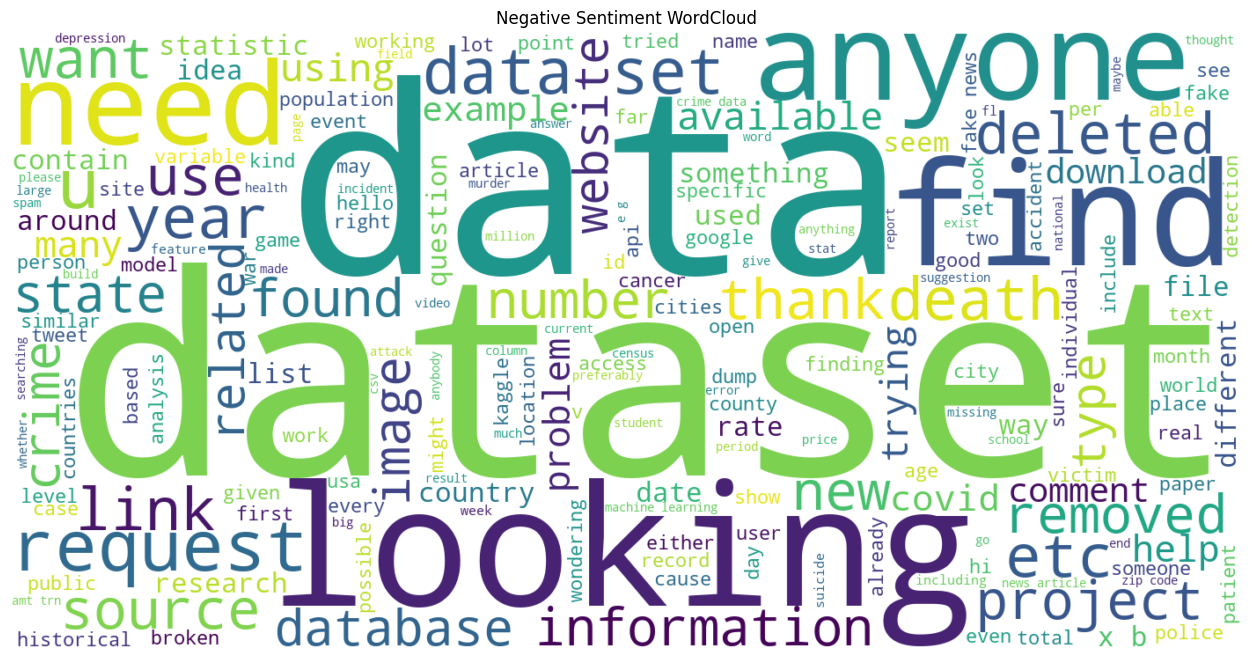

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
posts_df['sentiment'] = posts_df['cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

pos_df = posts_df[posts_df['sentiment'] > 0.3]
neg_df = posts_df[posts_df['sentiment'] < -0.3]

plot_wc(pos_df, "Positive Sentiment WordCloud")
plot_wc(neg_df, "Negative Sentiment WordCloud")


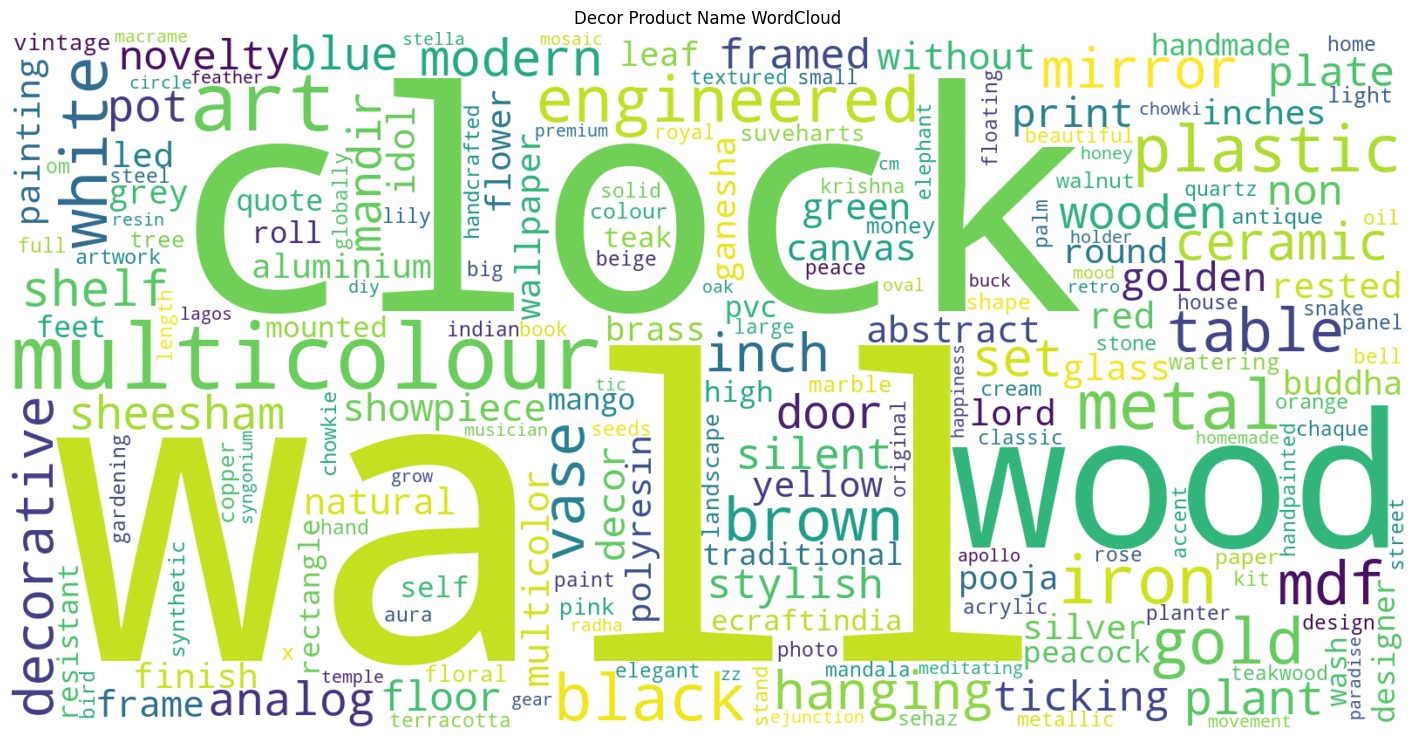

In [15]:
decor_clean = decor_df['name'].fillna('').apply(clean_text)
decor_text = " ".join(decor_clean)

wc = WordCloud(
    width=1600, height=800,
    background_color='white',
    stopwords=custom_stopwords,
    collocations=False
).generate(decor_text)

plt.figure(figsize=(18,10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Decor Product Name WordCloud")
plt.axis('off')
plt.show()
